In [1]:
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

%load_ext autoreload
%autoreload 2

from smc.smc import sequential_monte_carlo
from smc.sampling_algorithms import (
    systematic_resample,
    stratified_resample,
    multinomial_resample
)
from smc.utils import lambda_schedule
from datasets import checkerboard

from smc_scripts.plot_utils import plot_smc_results_binarized_mnist
from smc.proposals import (
    reverse_as_proposal, 
    first_order_approximation_optimal_proposal, 
    first_order_approximation_optimal_proposal_with_gradient_clipping
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

Using device: cuda


## Load pre-trained mdm model

In [2]:

from models.discrete_diffusion.udm import UniformDiffusion
from models.denoising_models.unet_with_attention import UNetWithAttention

batch_size = 64
vocab_size = 2
num_categories = vocab_size
input_shape = (1, 28, 28)
num_timesteps = 100

pretrained_model = UniformDiffusion(
    denoising_model=UNetWithAttention(
        num_categories=num_categories,
        embedding_dim=64,
        ch_mult=(2, 4, 8),
        num_res_blocks=2,
        attention_resolutions=(1, 2),
        encode_time=True,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    noise_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
pretrained_model.load_state_dict(torch.load('../model_weights/udm_binarized_mnist_256.pth'))

<All keys matched successfully>

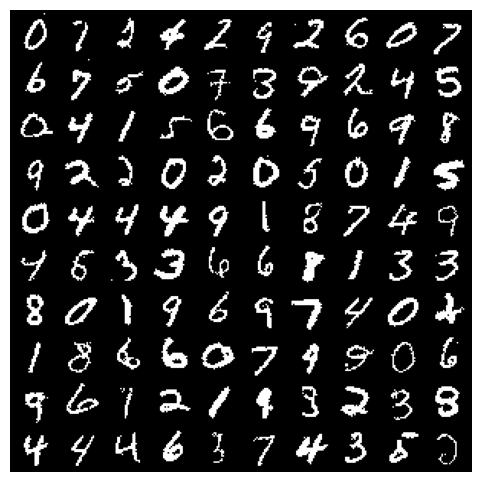

In [3]:
# Visualize samples
pretrained_model.eval()
with torch.no_grad():
    samples = pretrained_model.sample(num_samples=100, device=device).float().cpu()
grid = utils.make_grid(samples, nrow=10, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).squeeze().cpu().numpy(), cmap="gray")
plt.axis('off')
plt.show()

## Define Reward, KL penalty coefficient, and Corresponding Target Distribution

In [21]:
from models.reward_models.binarized_mnist_classifier import BinarizedMNISTClassifier
import torch
mnist_classfier_model = BinarizedMNISTClassifier().to(device)
mnist_classfier_model.load_state_dict(torch.load('../model_weights/binarized_mnist_classifier_1.pth'))

def compute_rewards_for_batch(x: Tensor, with_grad=False):
    # x.shape : (B, 1, 28, 28, num_categories)
    logits = mnist_classfier_model(x[..., :vocab_size].to(device)) # Shape: (B, 10)
    logits = logits.log_softmax(dim=-1) # Shape: (B, 10)
    reward = logits[:, 4]
    return reward

def compute_rewards(x, with_grad=False):
    n_samples = x.shape[0]
    rewards_all = []
    for i in range(0, n_samples, batch_size):
        if with_grad:
            rewards = compute_rewards_for_batch(x[i:i + batch_size])
        else:
            with torch.no_grad():
                rewards = compute_rewards_for_batch(x[i:i + batch_size])
        rewards_all.append(rewards)
    rewards_all = torch.cat(rewards_all)
    return rewards_all

kl_weight = 1.

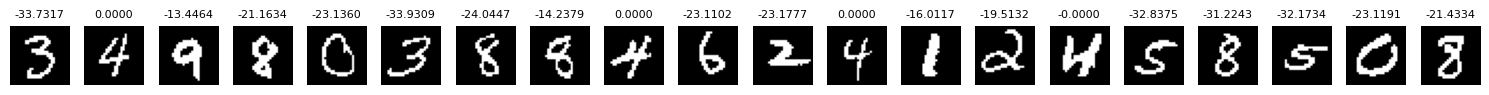

In [5]:
# Visualize rewards
from datasets.binarized_mnist import build_dataloaders
train_loader, test_loader = build_dataloaders(batch_size=20)
samples, _ = next(iter(train_loader))
rewards = compute_rewards(F.one_hot(samples.long(), num_classes=num_categories).float())

fig, axes = plt.subplots(1, 20, figsize=(15, 2))
for i in range(20):
    ax = axes[i]
    ax.imshow(samples[i].squeeze().cpu().numpy(), cmap="gray")
    ax.set_title(f"{rewards[i].item():.4f}", fontsize=8)
    ax.axis("off")
plt.tight_layout()
plt.show()

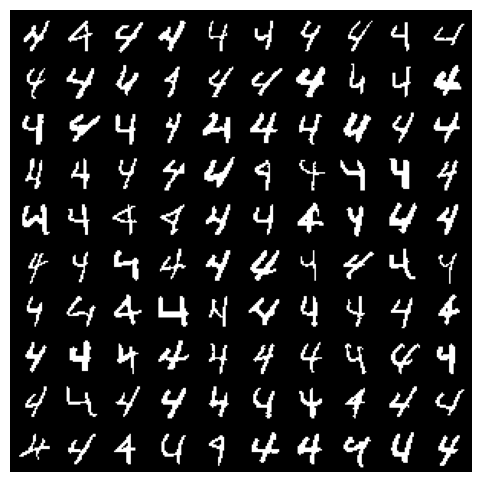

Target Reward: -0.0017114006914198399
Diversity: 99


In [6]:
from datasets.binarized_mnist import build_dataloaders

def target_distribution_log_pdf(x, kl_weight):
    reward = compute_rewards(F.one_hot(x, num_classes=num_categories).float())
    return reward / kl_weight

def sample_target_distribution(n_samples, kl_weight):
    train_loader, test_loader = build_dataloaders(batch_size=batch_size, shuffle_train=False)
    log_pdf_values = []
    for samples, _ in train_loader:
        samples = samples.long()
        log_pdf_values.append(target_distribution_log_pdf(samples, kl_weight))
    log_pdf_values = torch.cat(log_pdf_values, dim=0)
    indices = torch.distributions.Categorical(logits=log_pdf_values).sample((n_samples,))
    return torch.stack([train_loader.dataset[i][0].long() for i in indices])

target_samples = sample_target_distribution(100, kl_weight)

grid = utils.make_grid(target_samples, nrow=10, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).squeeze().float().cpu().numpy(), cmap="gray")
plt.axis('off')
plt.show()

target_rewards = compute_rewards(
    F.one_hot(target_samples, num_classes=num_categories).float()
)
print(f"Target Reward: {target_rewards.mean().item()}")
print(f"Diversity: {torch.unique(target_samples, dim=0).shape[0]}")

In [7]:
def intialize_particles(num_particles, device=device):
    particles = torch.randint(low=0, high=vocab_size, size=(num_particles, *input_shape), device=device, requires_grad=False)
    return particles

### Define the lambdas schedule and other parameters

1


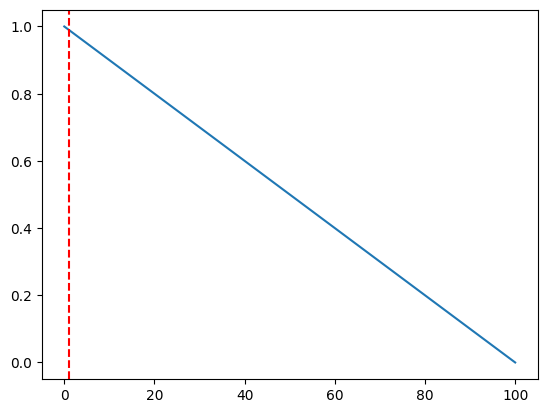

In [27]:
num_particles = 20
ESS_min = 15
# lambdas = lambda_schedule(num_timesteps, gamma=0.05)
# lambdas = lambda_schedule(num_timesteps, base=2.0)
lambdas = np.linspace(1.0, 0.0, num_timesteps+1)
reward_estimate_sample_count = 1
use_partial_resampling = True
perform_final_resample = False
partial_resample_size = num_particles // 2

plt.plot(np.arange(num_timesteps+1), lambdas)
lambda_1 = np.where(np.array(lambdas) >= 0.99)[0][-1]
print(lambda_1)
plt.axvline(lambda_1, color="red", linestyle="--")

## Reverse diffusion as proposal

100%|██████████| 100/100 [00:06<00:00, 15.53it/s]


Resampled 30 times.


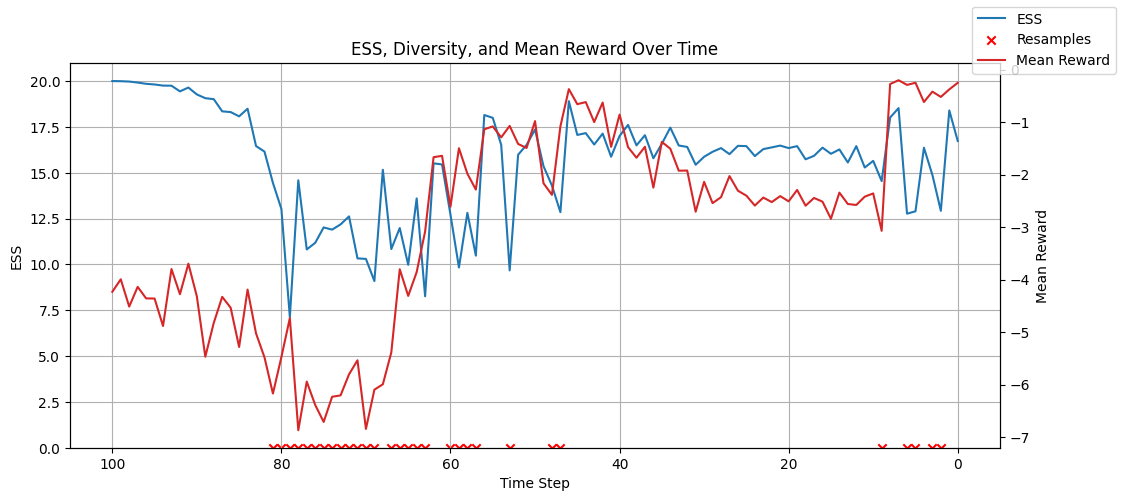

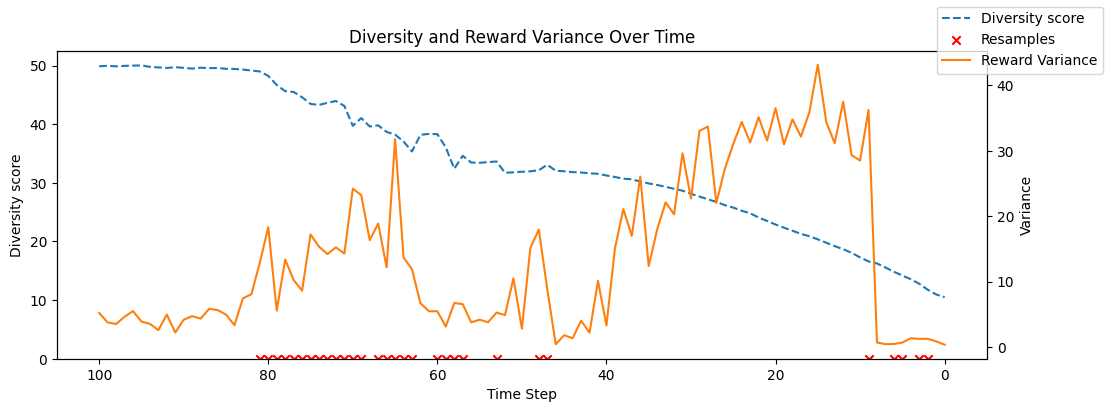

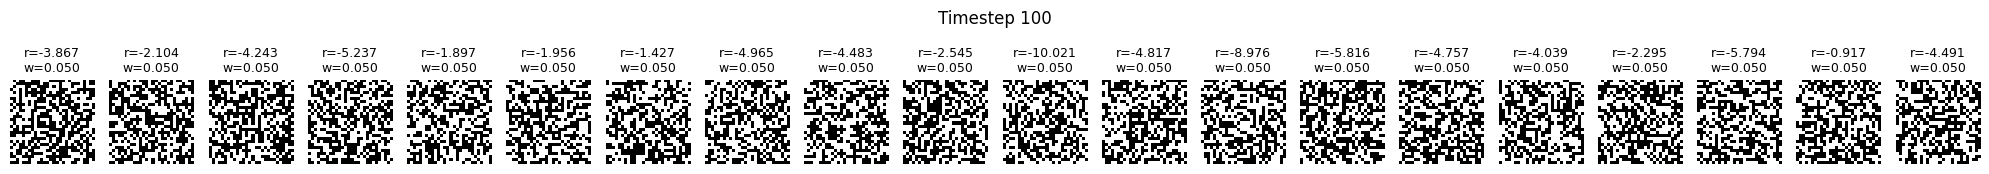

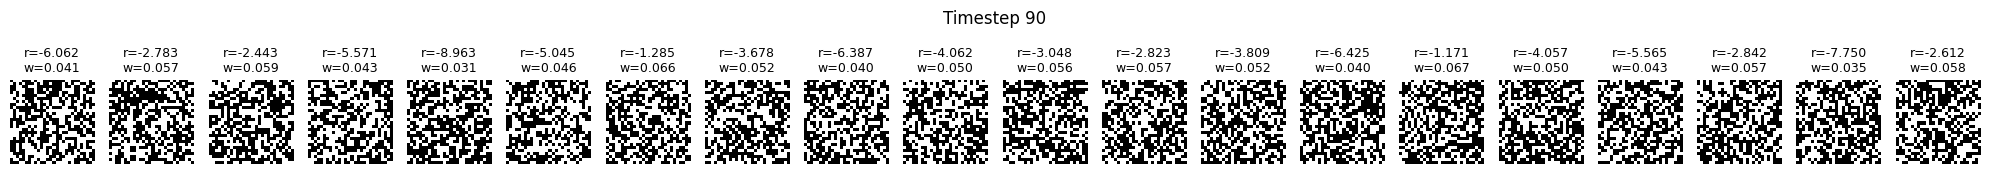

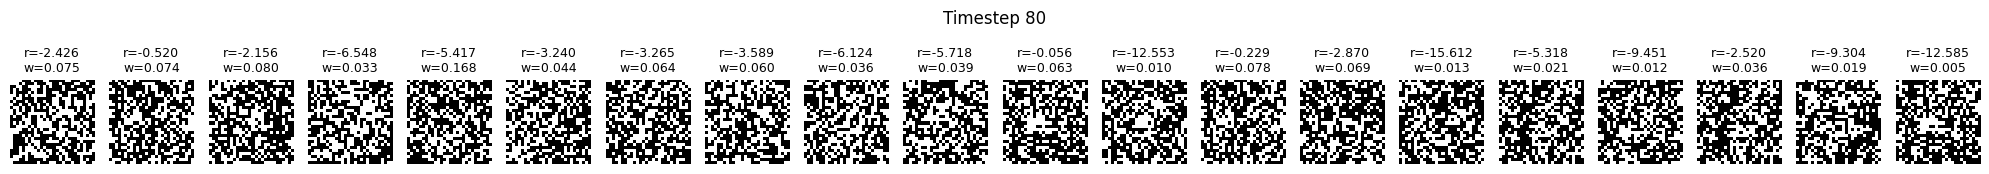

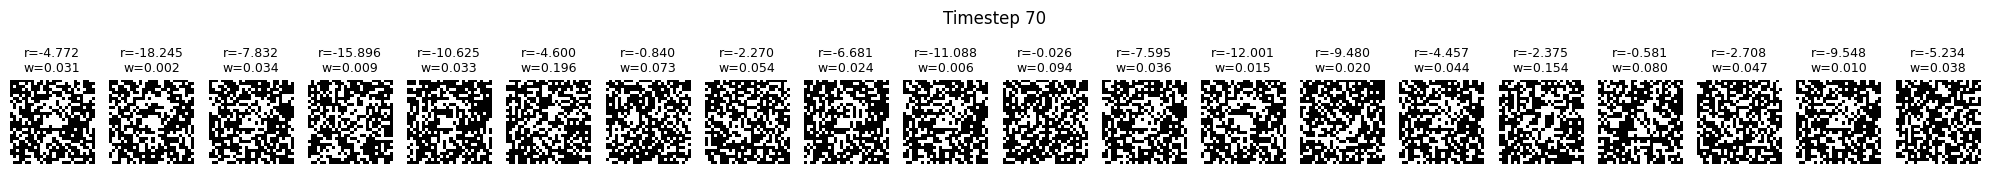

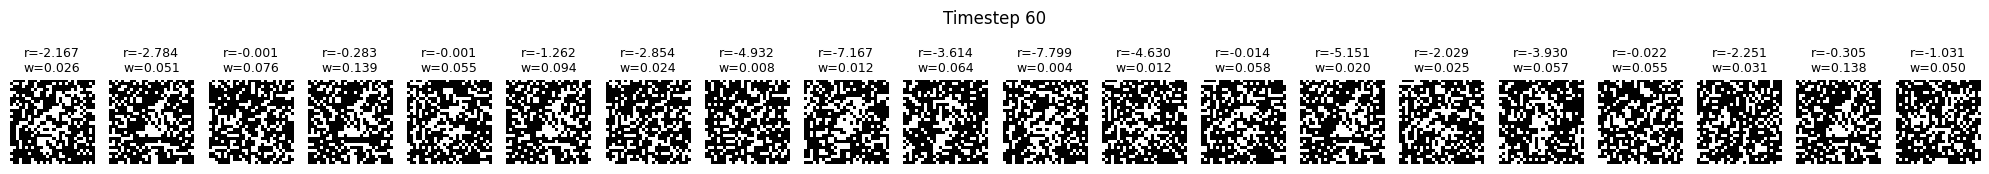

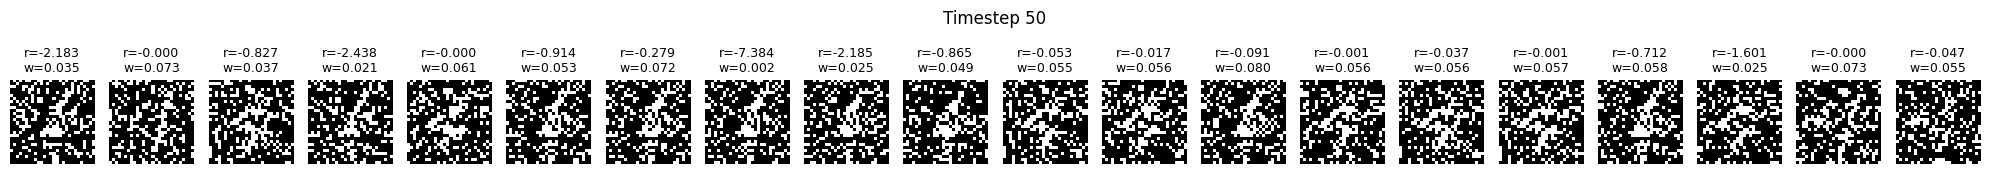

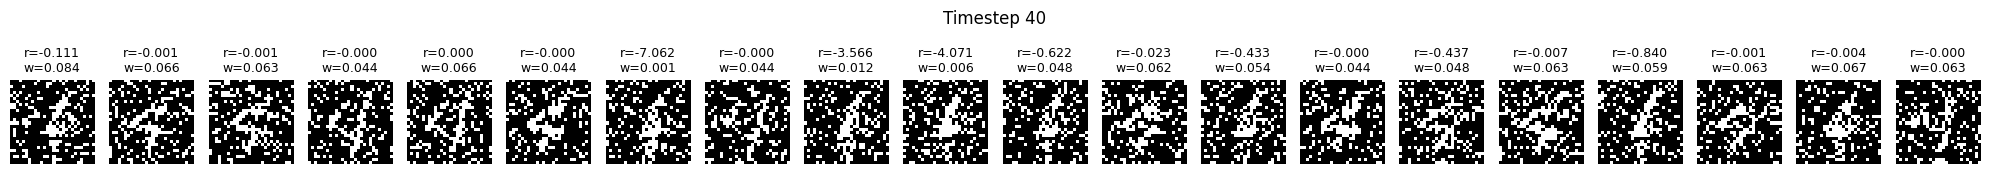

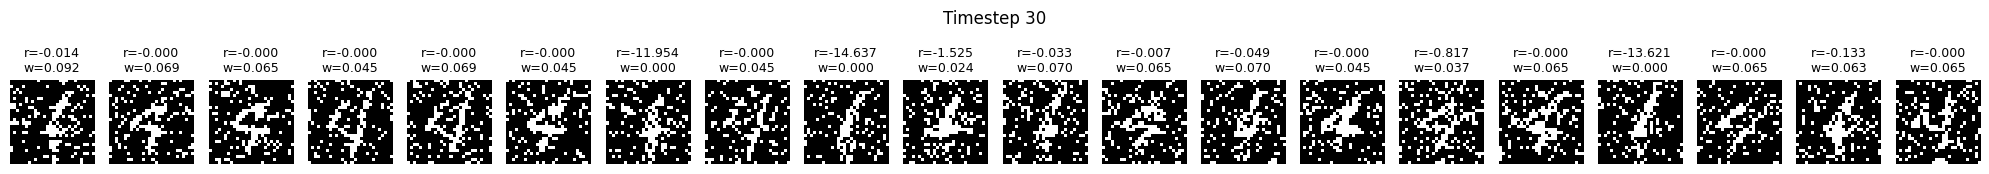

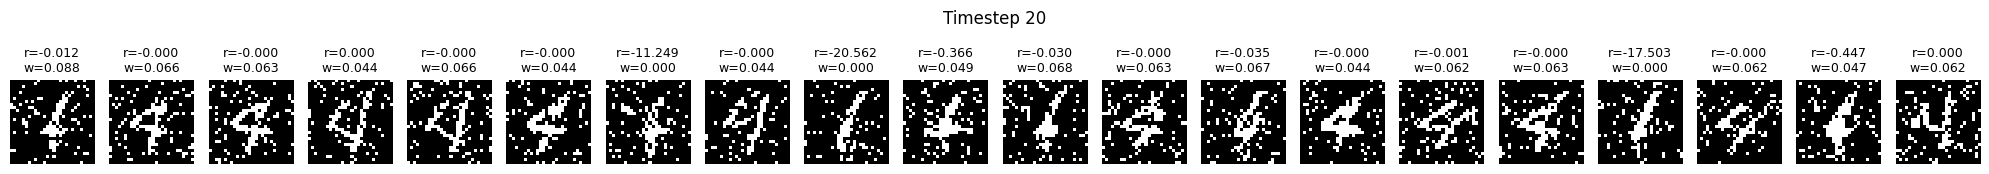

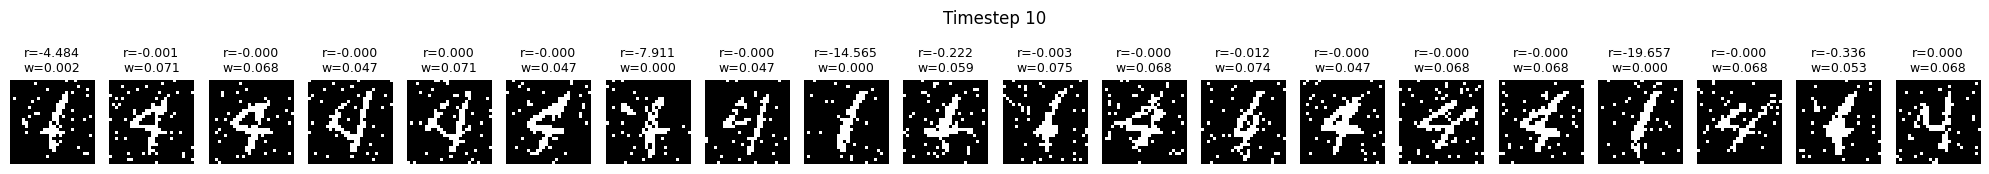

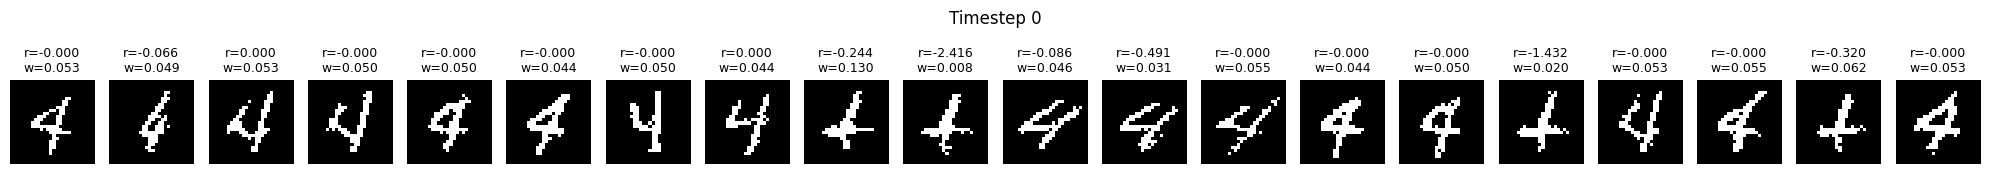

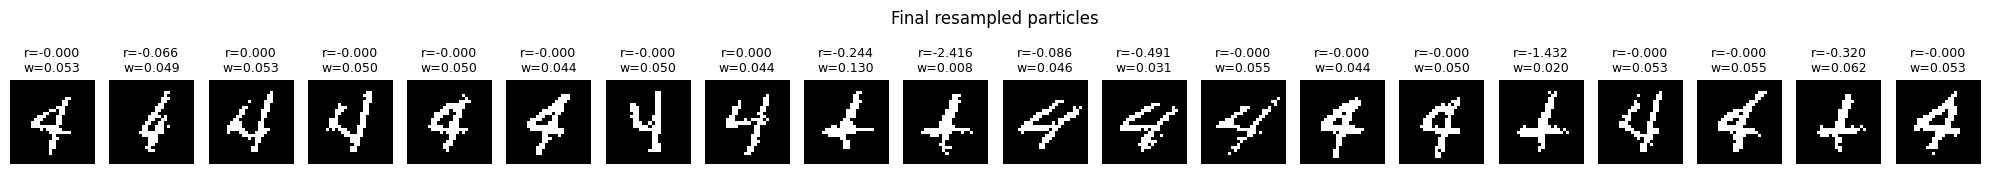

Final average reward: -0.2527
Final diversity score: 10.49
Final uniqueness: 20


In [29]:
reverse_as_proposal_results = sequential_monte_carlo(
    model=pretrained_model,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=ESS_min,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    use_partial_resampling=use_partial_resampling,
    partial_resample_size=partial_resample_size,
    proposal_fn=reverse_as_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=reward_estimate_sample_count,
    perform_final_resample=perform_final_resample,
    device=device,
    verbose=False,
)
reverse_as_proposal_metrics = plot_smc_results_binarized_mnist(reverse_as_proposal_results, num_timesteps, vocab_size, num_categories, compute_rewards)

## First order approximate proposal

100%|██████████| 100/100 [00:06<00:00, 15.70it/s]


Resampled 25 times.


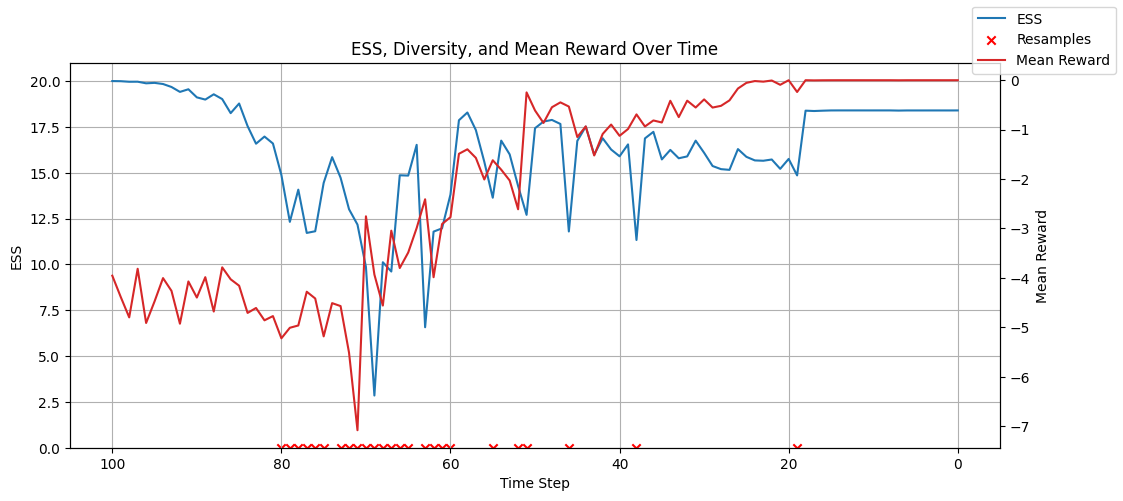

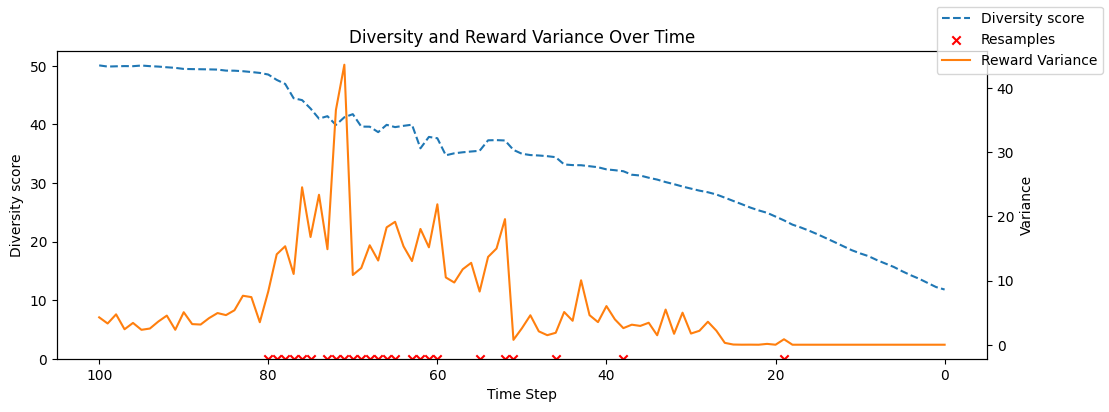

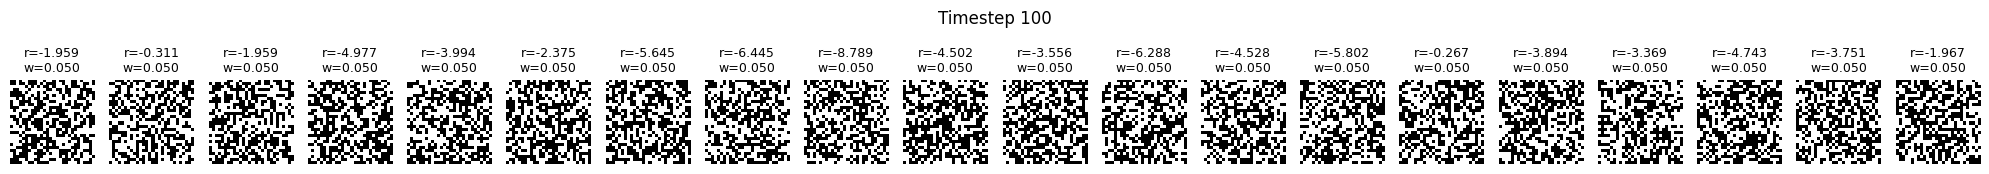

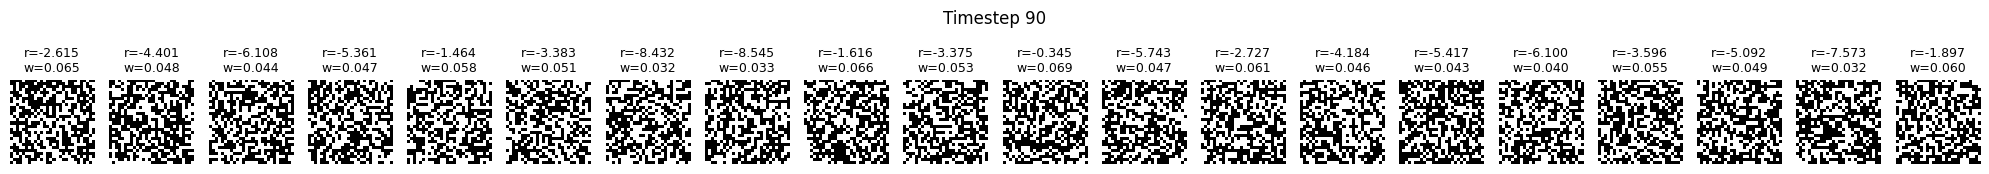

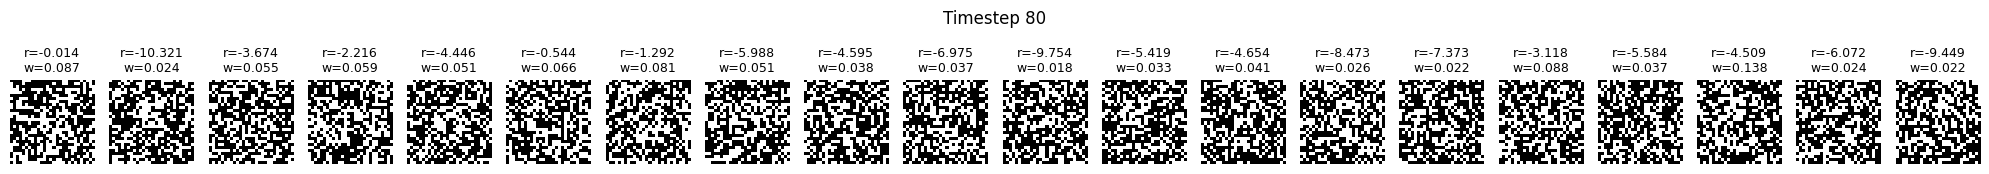

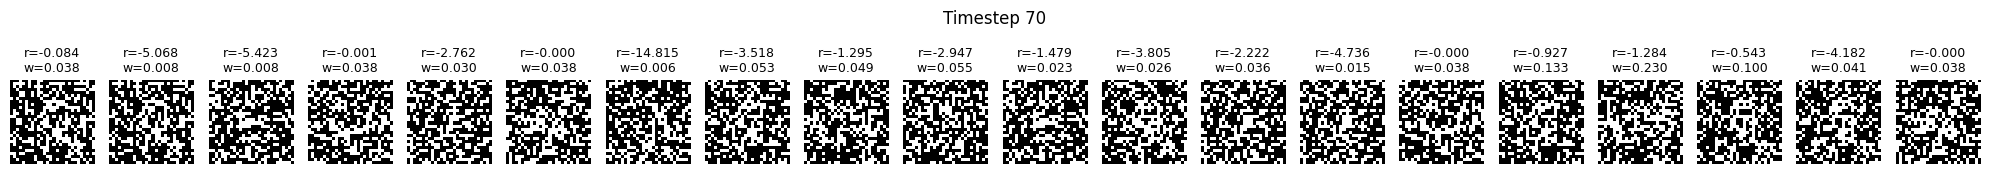

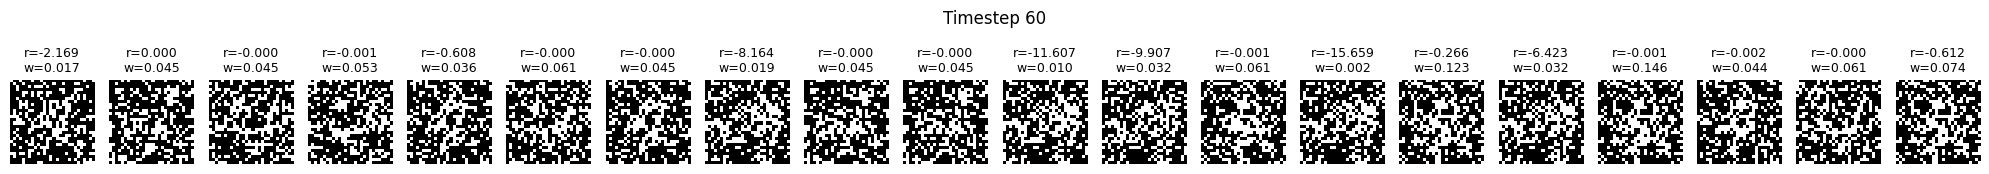

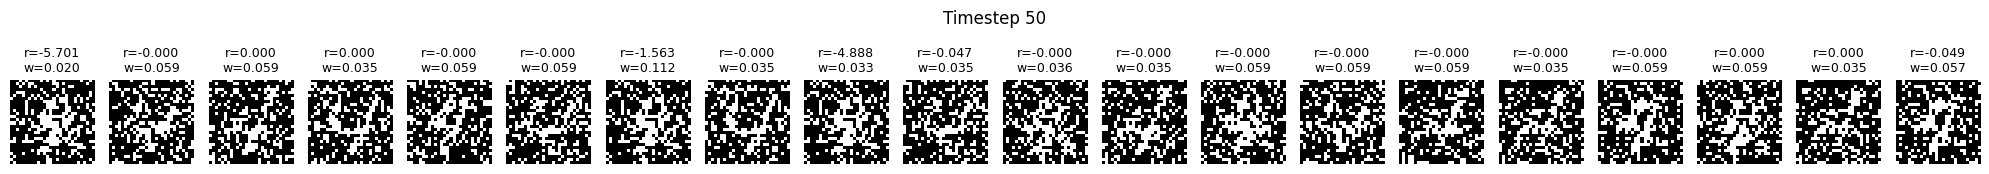

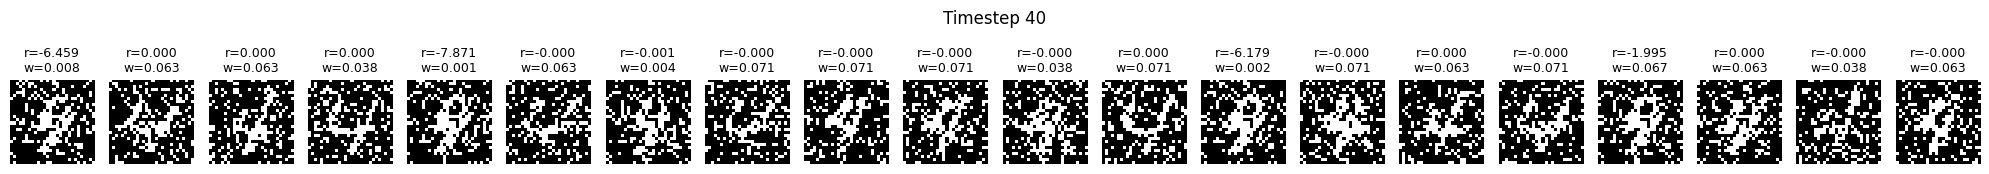

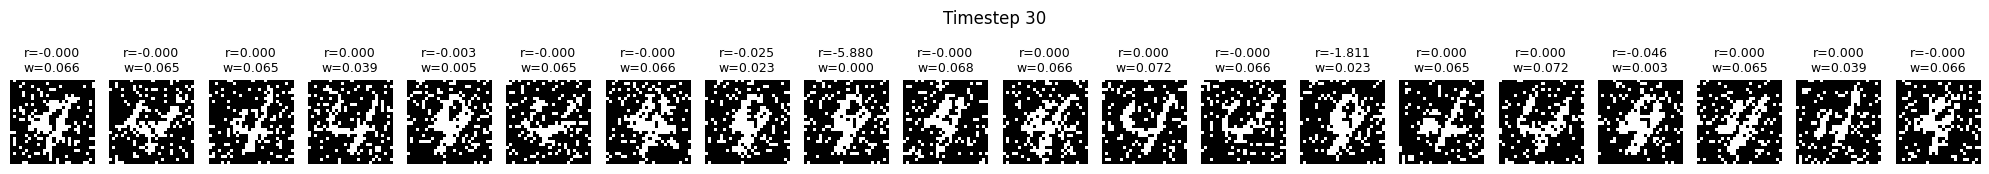

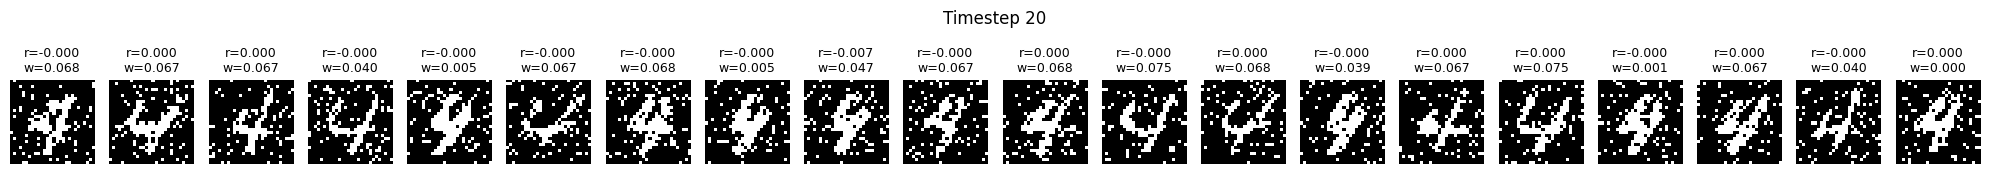

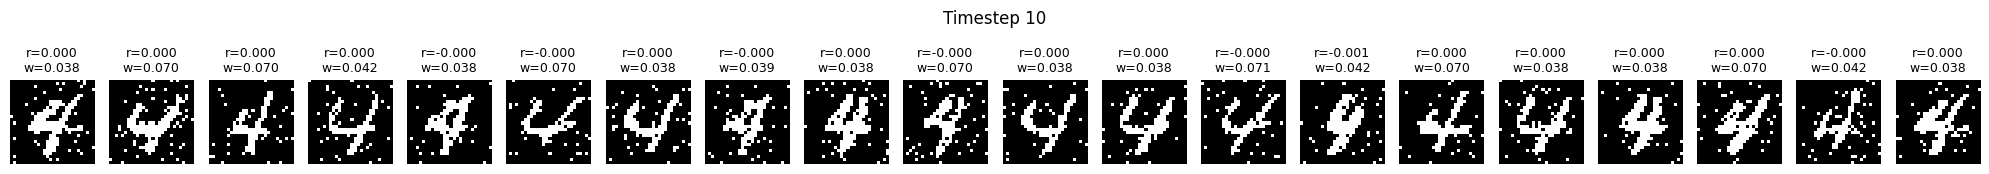

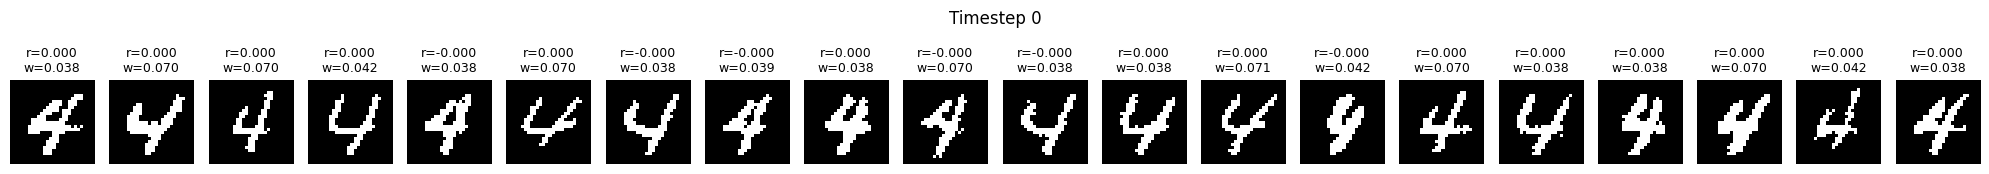

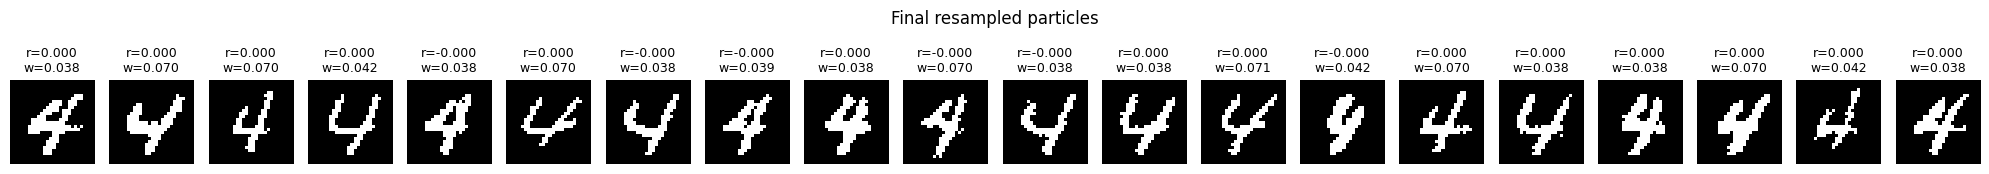

Final average reward: -0.0000
Final diversity score: 11.81
Final uniqueness: 15


In [28]:
first_order_results = sequential_monte_carlo(
    model=pretrained_model,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=ESS_min,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    use_partial_resampling=use_partial_resampling,
    partial_resample_size=partial_resample_size,
    proposal_fn=first_order_approximation_optimal_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=reward_estimate_sample_count,
    perform_final_resample=perform_final_resample,
    device=device,
    verbose=False,
)
first_order_metrics = plot_smc_results_binarized_mnist(first_order_results, num_timesteps, vocab_size, num_categories, compute_rewards)

## Approximate Guidance

In [11]:
lambdas_no_tempering = torch.ones(len(lambdas))

100%|██████████| 100/100 [00:06<00:00, 15.55it/s]


Resampled 0 times.


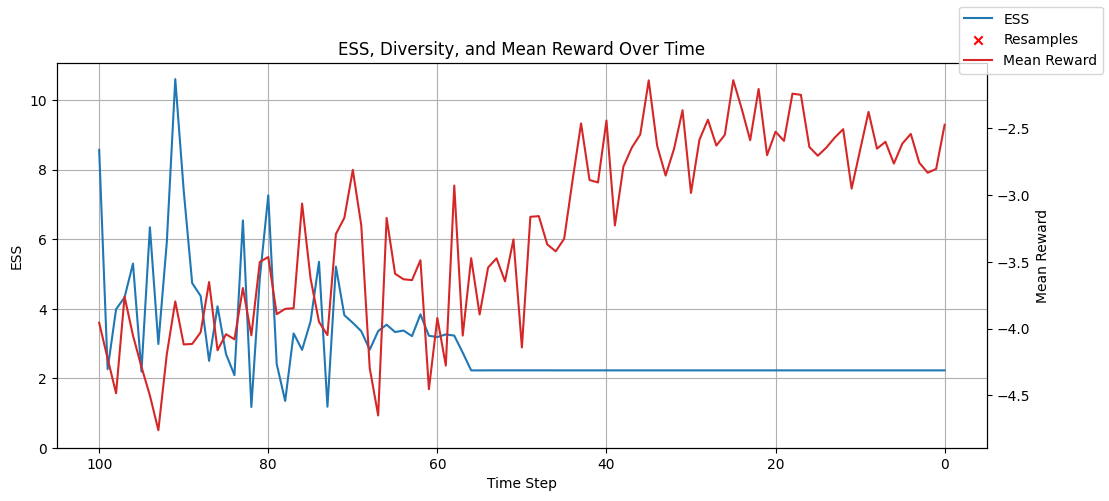

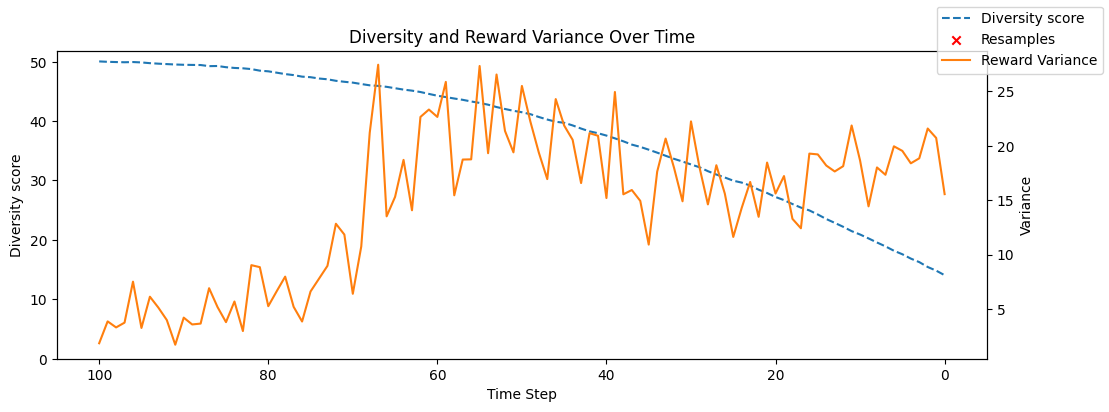

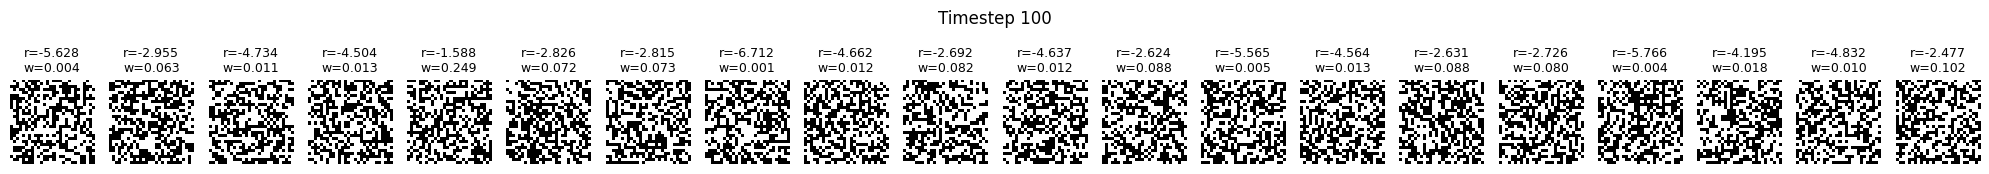

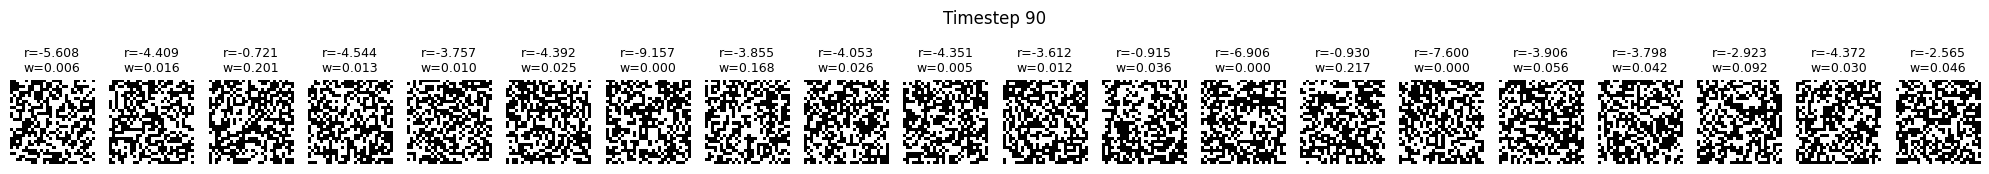

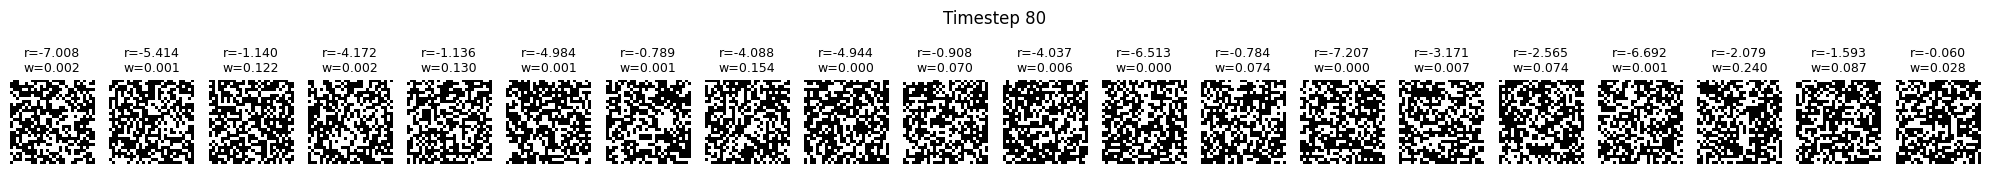

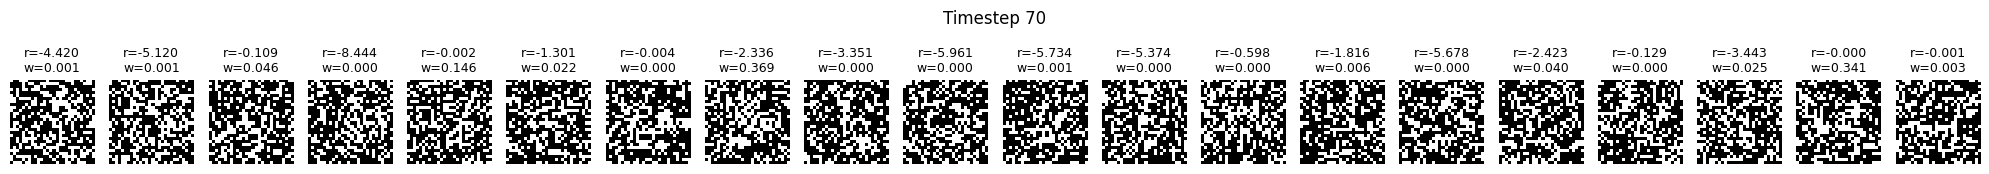

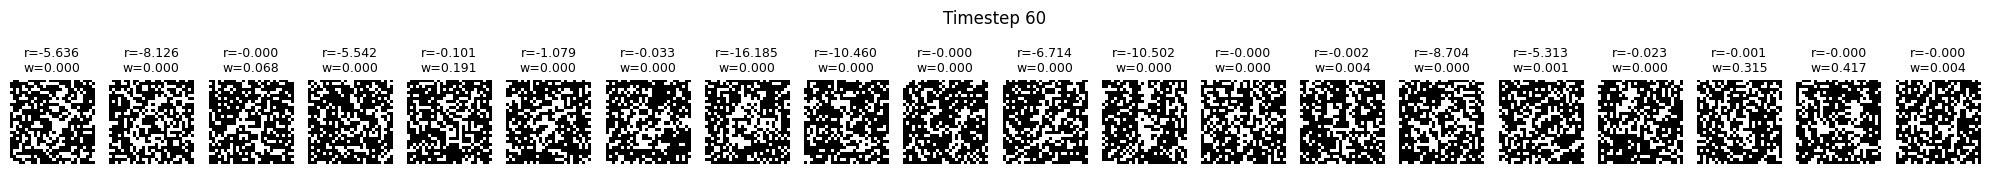

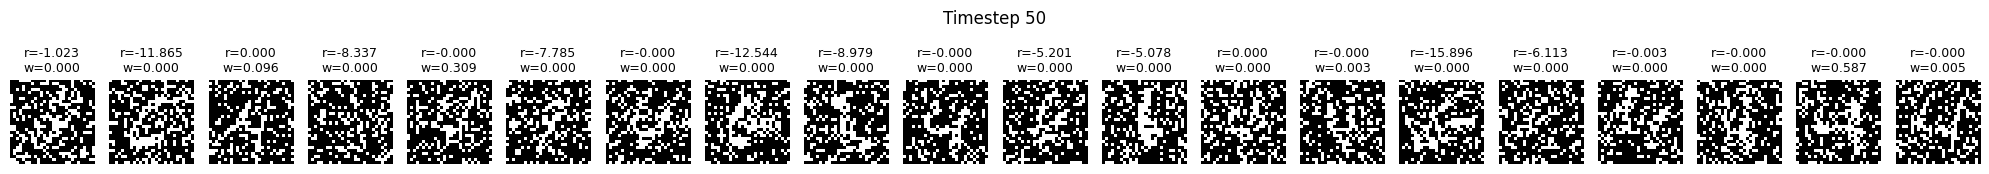

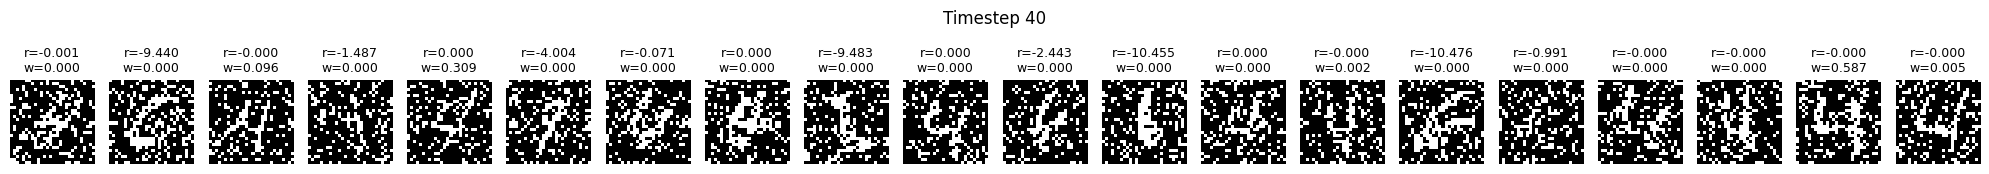

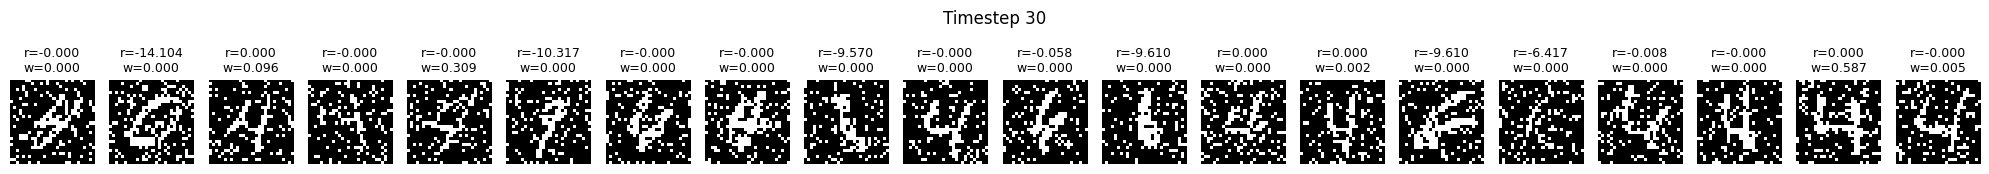

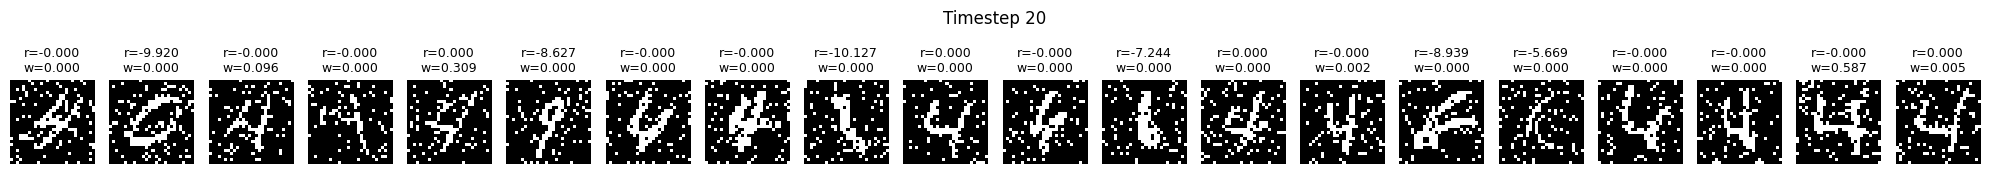

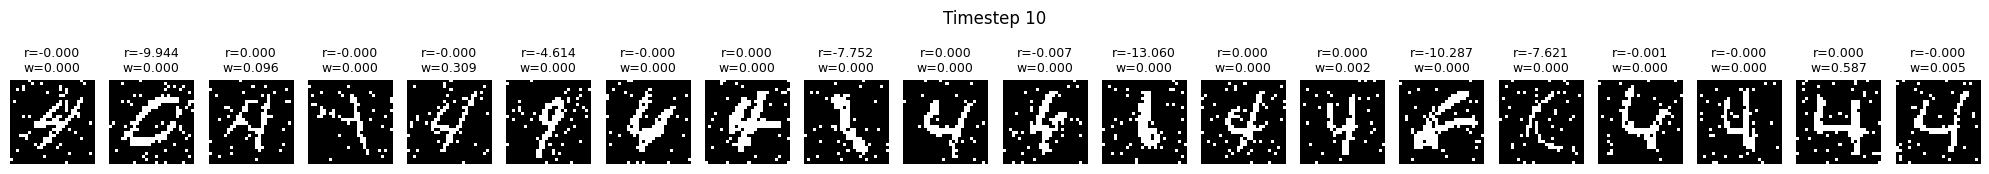

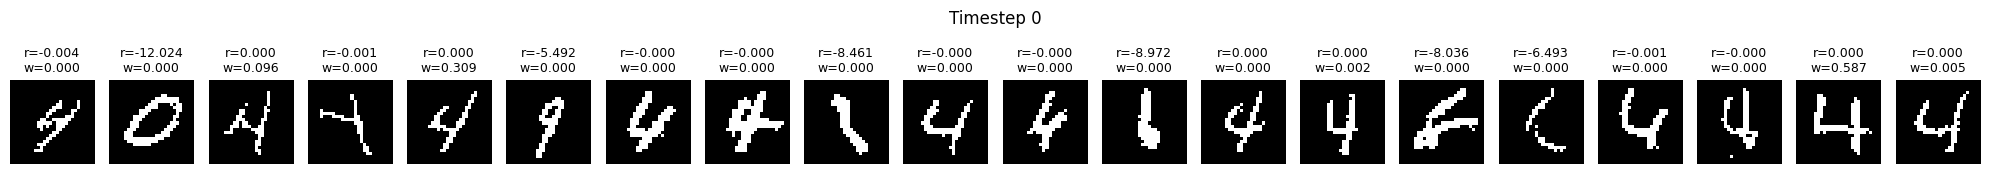

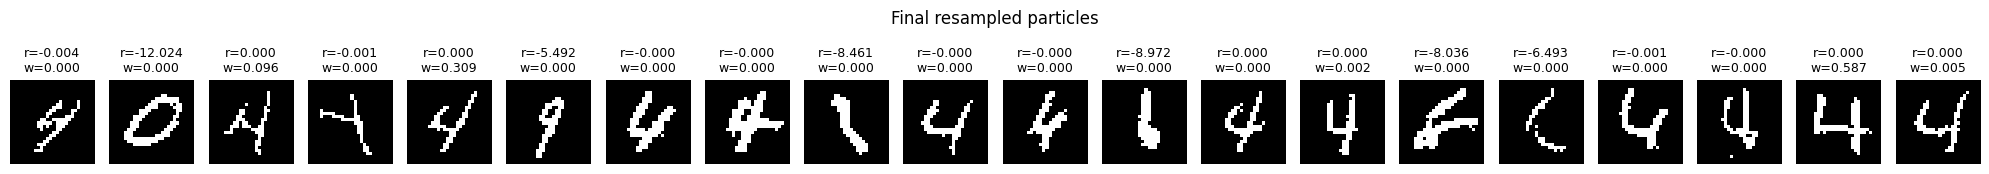

Final average reward: -2.4742
Final diversity score: 14.06
Final uniqueness: 20


In [30]:
approx_guidance_results = sequential_monte_carlo(
    model=pretrained_model,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=-1,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    use_partial_resampling=use_partial_resampling,
    partial_resample_size=partial_resample_size,
    proposal_fn=first_order_approximation_optimal_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas_no_tempering,
    kl_weight=kl_weight,
    reward_estimate_sample_count=reward_estimate_sample_count,
    perform_final_resample=False,
    device=device,
    verbose=False,
)
approx_guidance_metrics = plot_smc_results_binarized_mnist(approx_guidance_results, num_timesteps, vocab_size, num_categories, compute_rewards)

### With tempering

100%|██████████| 100/100 [00:06<00:00, 16.39it/s]


Resampled 0 times.


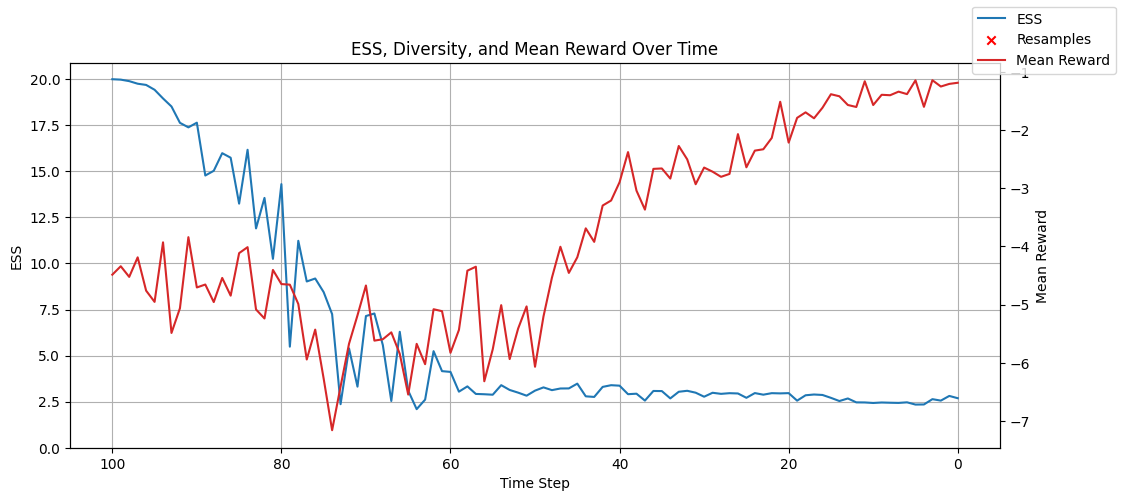

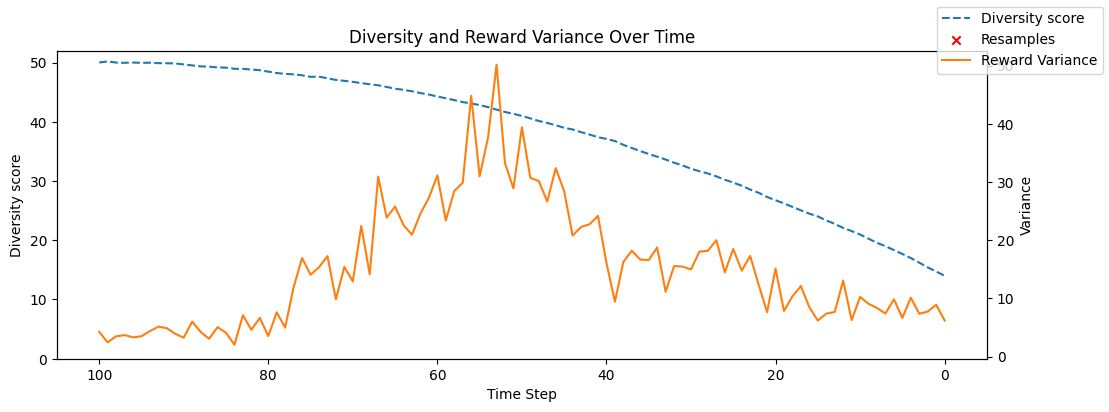

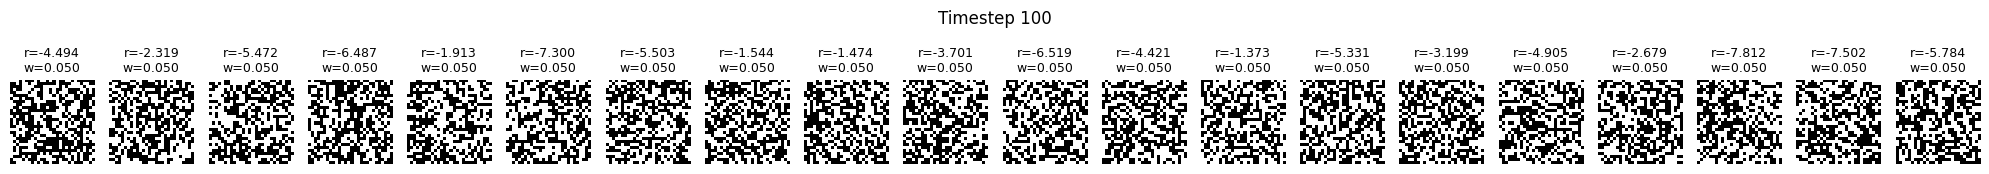

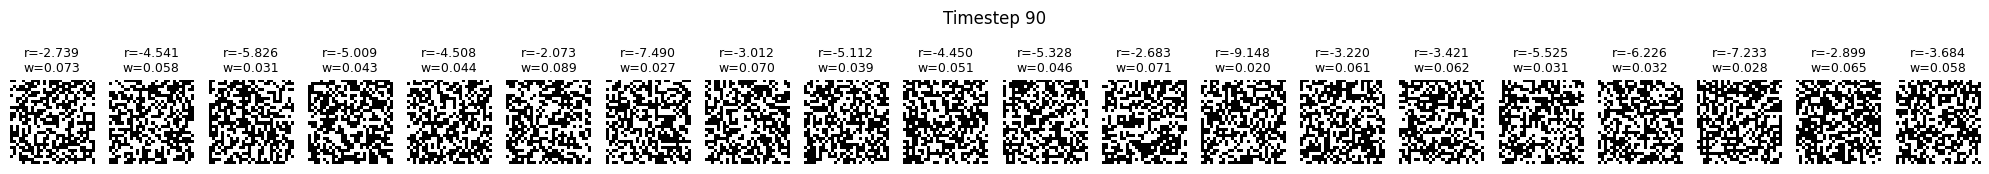

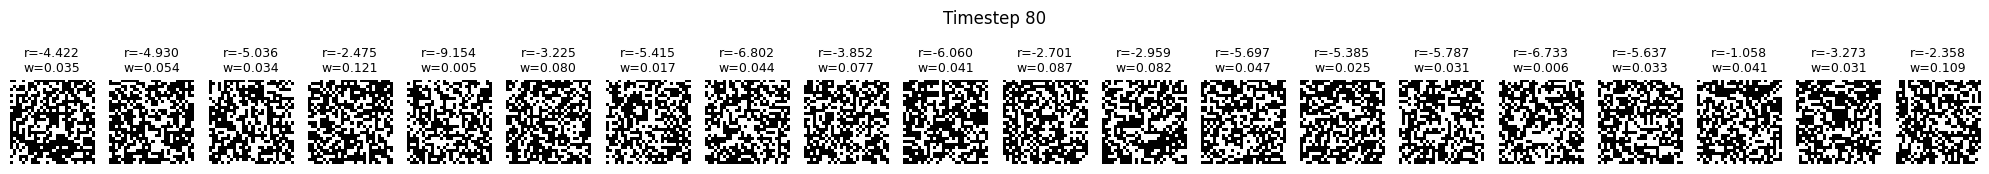

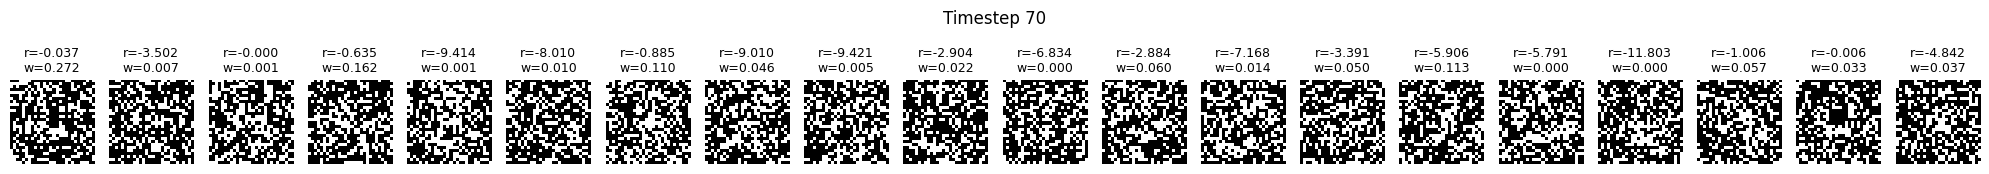

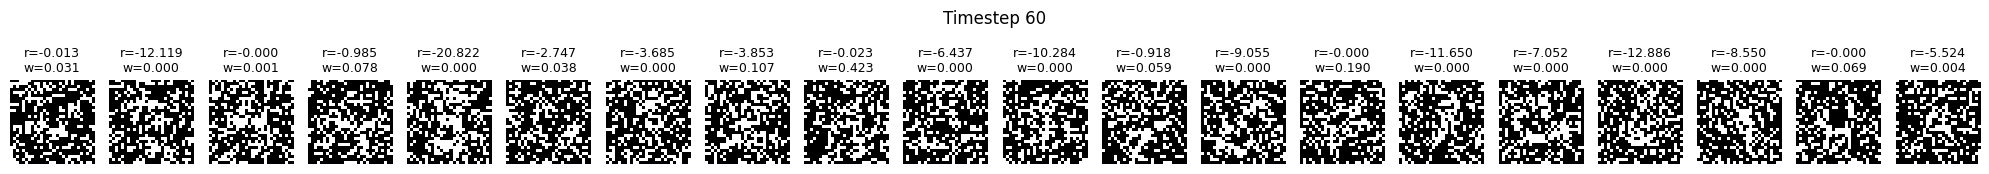

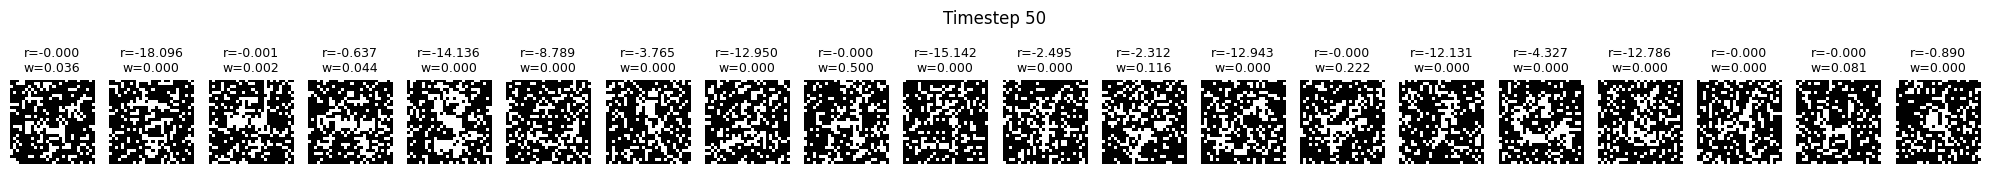

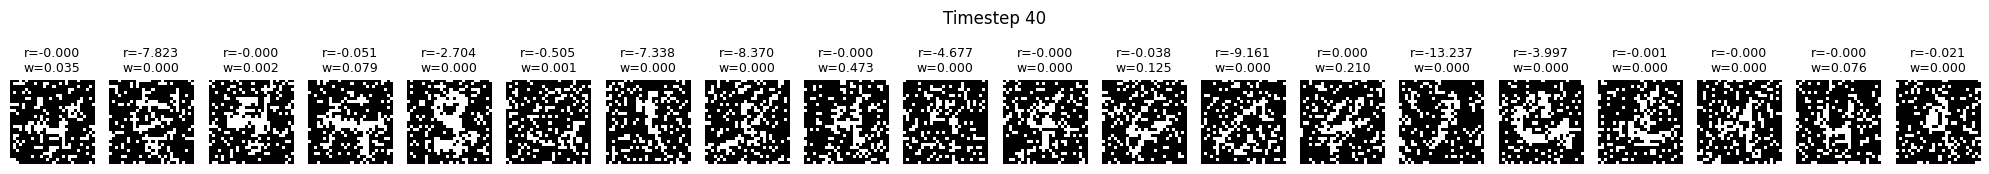

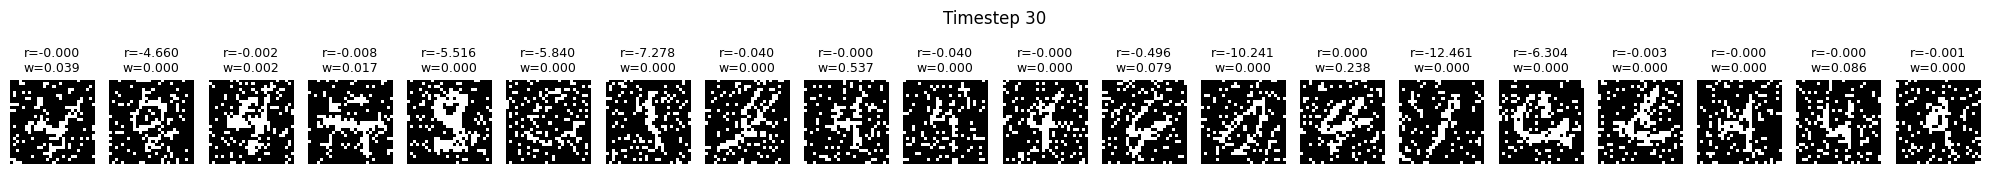

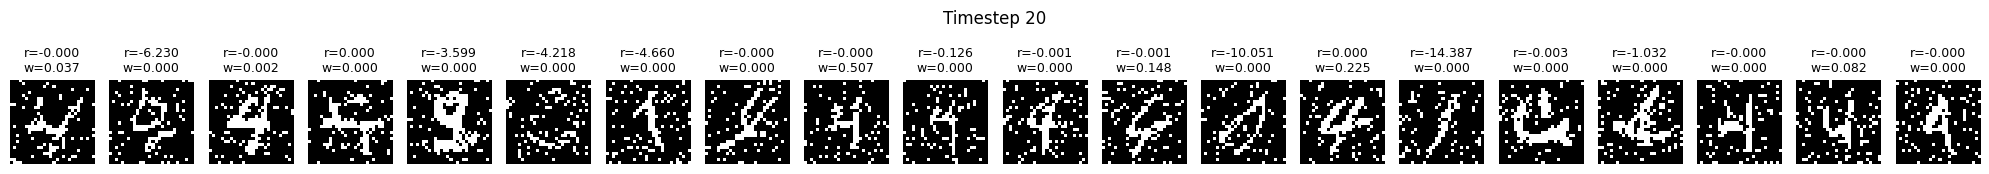

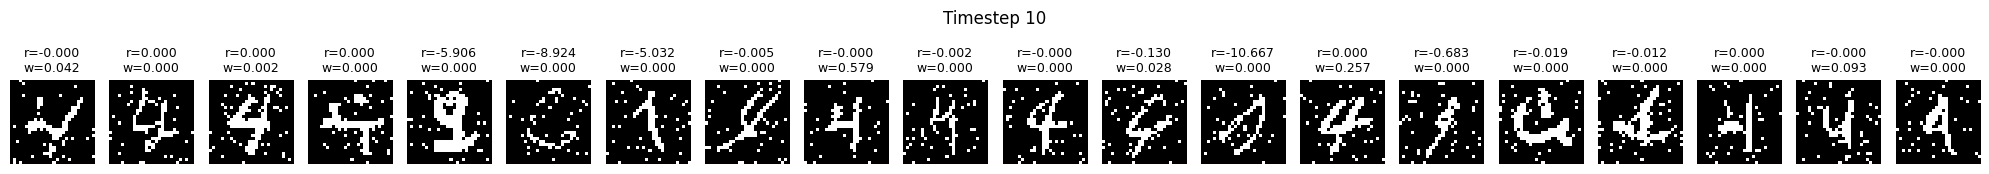

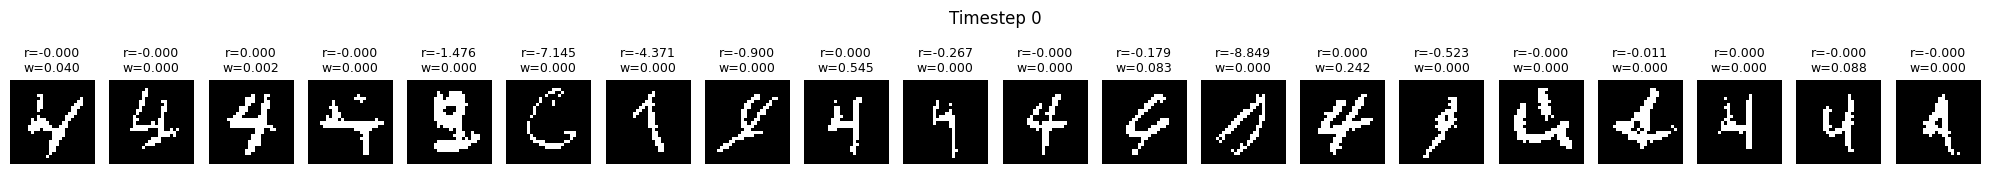

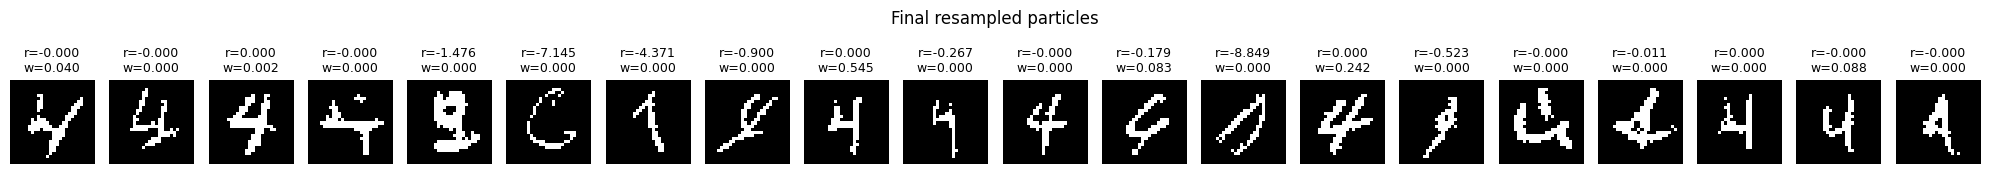

Final average reward: -1.1860
Final diversity score: 14.00
Final uniqueness: 20


{'reward': -1.186008095741272,
 'diversity': 14.003759398496237,
 'uniqueness': 20}

In [13]:
result = sequential_monte_carlo(
    model=pretrained_model,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=-1,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    use_partial_resampling=use_partial_resampling,
    partial_resample_size=partial_resample_size,
    proposal_fn=first_order_approximation_optimal_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=reward_estimate_sample_count,
    perform_final_resample=False,
    device=device,
    verbose=False,
)
plot_smc_results_binarized_mnist(result, num_timesteps, vocab_size, num_categories, compute_rewards)

## Debiased guidance

100%|██████████| 100/100 [00:06<00:00, 14.81it/s]


Resampled 25 times.


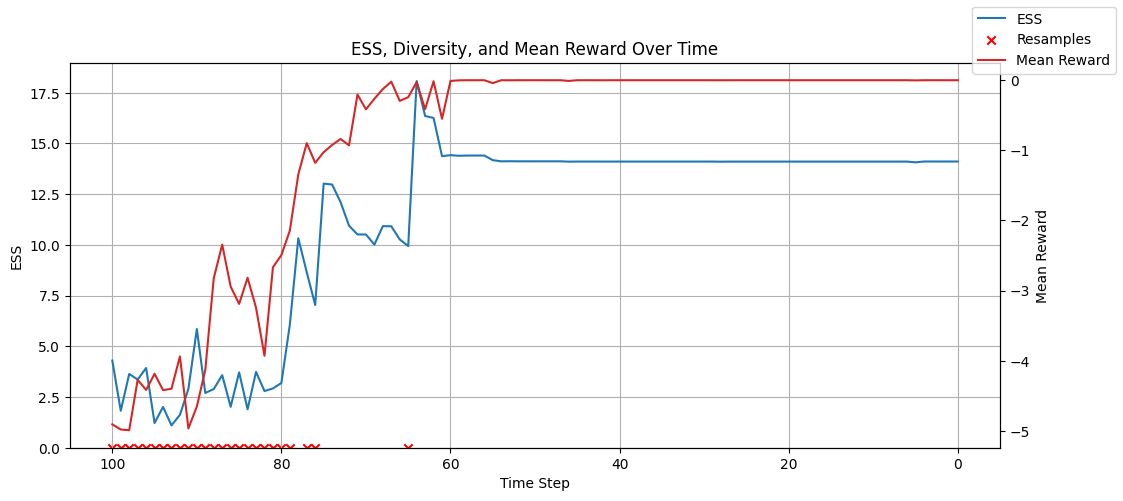

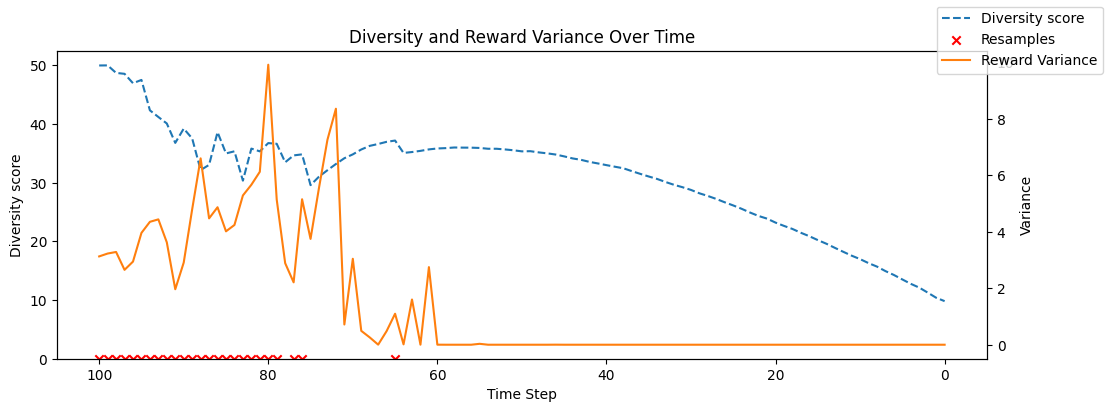

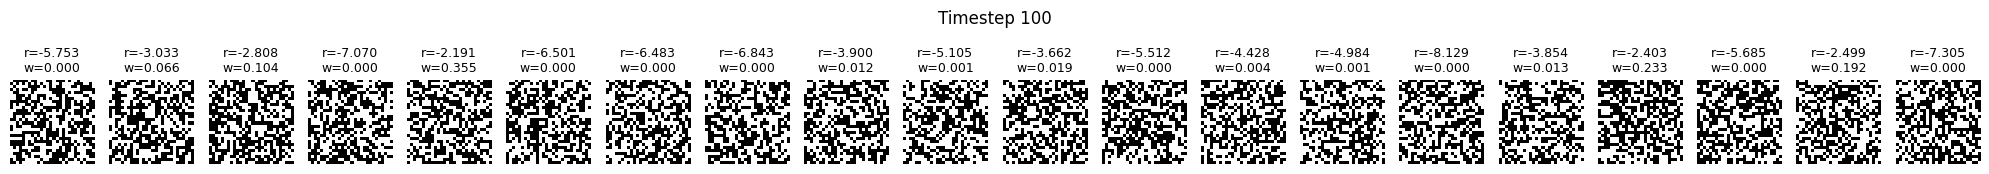

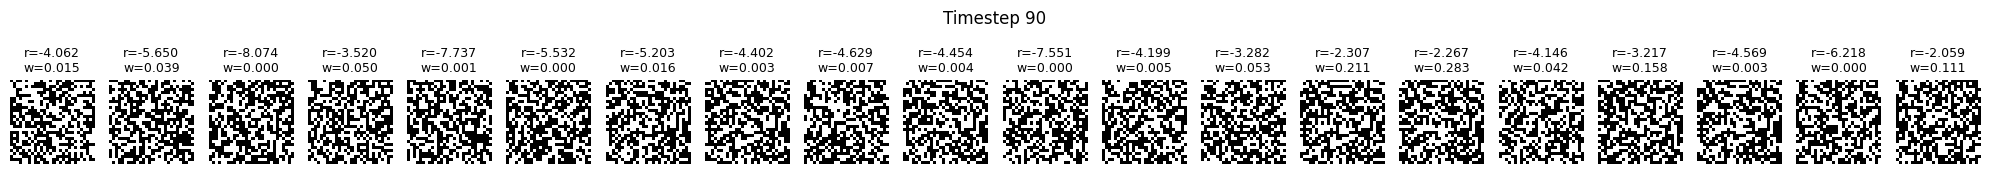

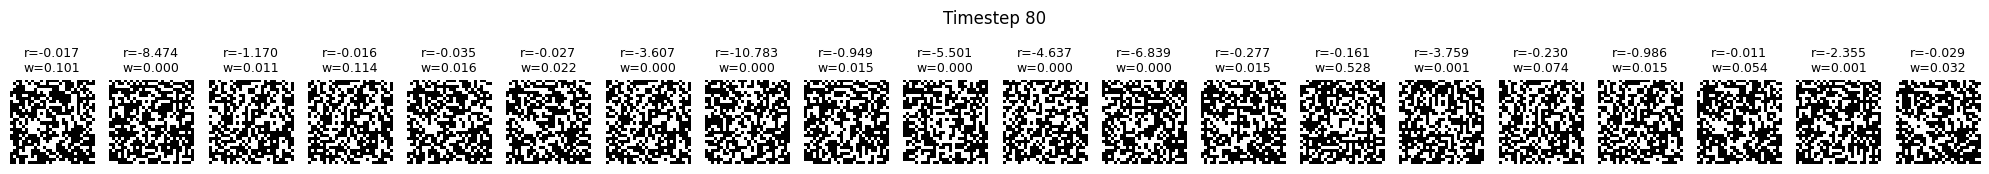

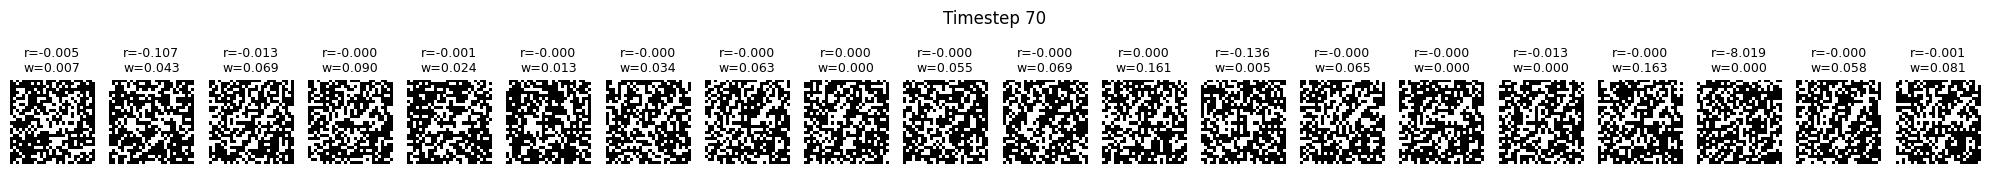

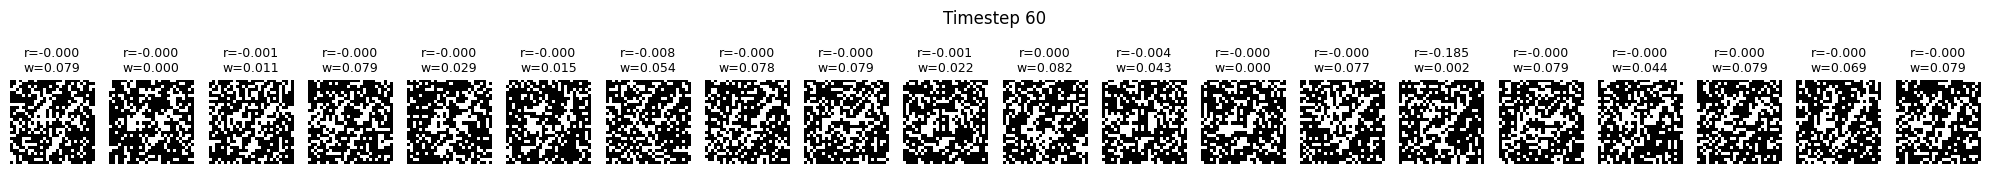

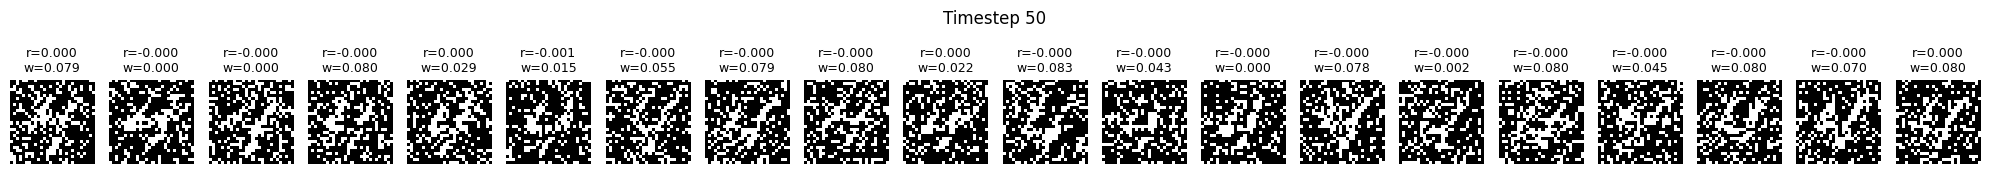

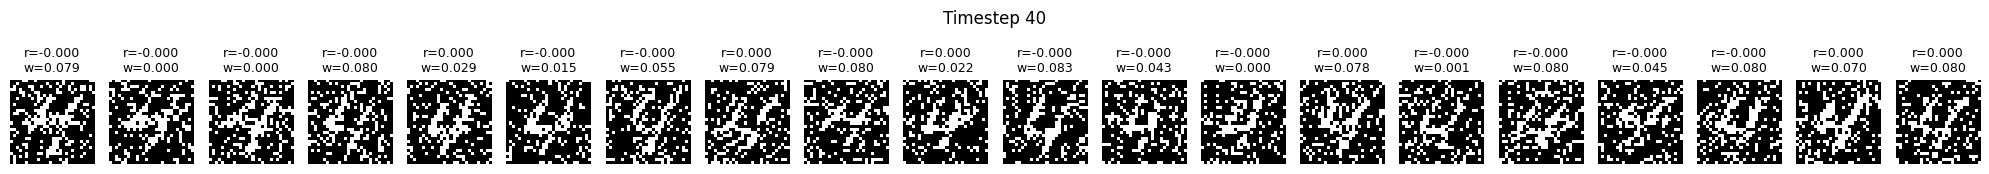

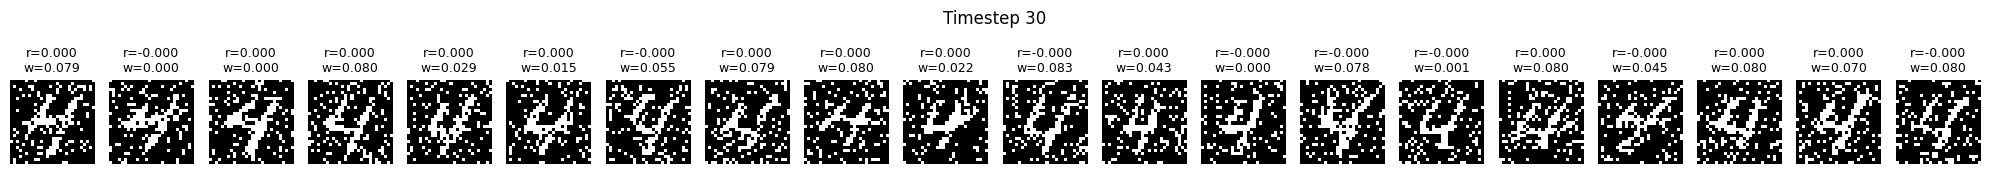

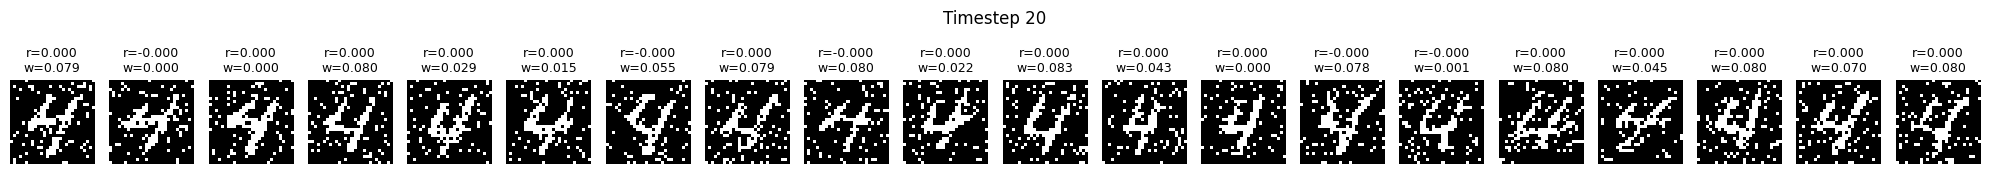

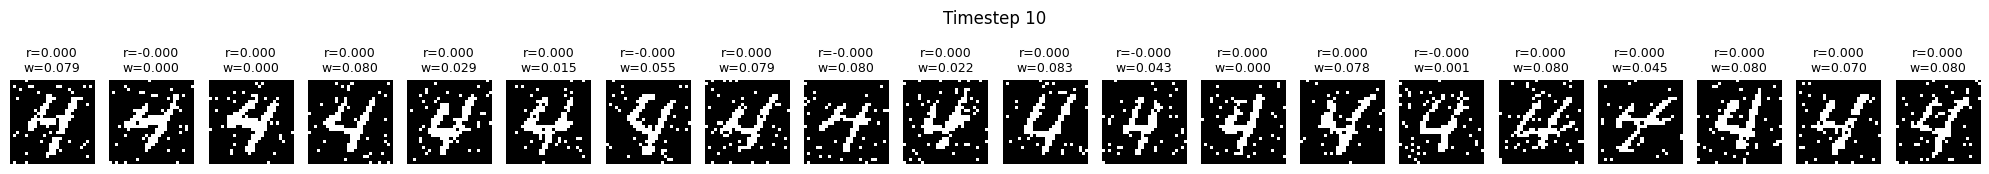

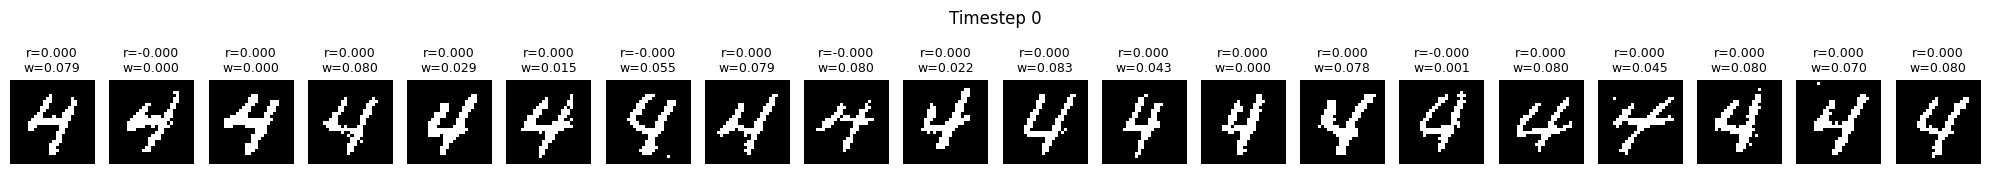

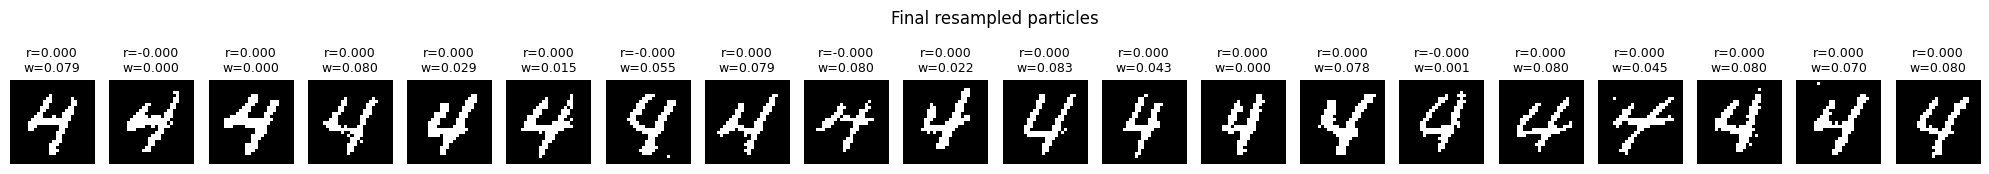

Final average reward: -0.0000
Final diversity score: 9.81
Final uniqueness: 20


{'reward': -1.1503633459142293e-06,
 'diversity': 9.814715359828137,
 'uniqueness': 20}

In [14]:
from smc.proposals import debiasing_guidance
result = sequential_monte_carlo(
    model=pretrained_model,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=ESS_min,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    use_partial_resampling=use_partial_resampling,
    partial_resample_size=partial_resample_size,
    proposal_fn=debiasing_guidance,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas_no_tempering,
    kl_weight=kl_weight,
    reward_estimate_sample_count=reward_estimate_sample_count,
    perform_final_resample=perform_final_resample,
    device=device,
    verbose=False,
)
plot_smc_results_binarized_mnist(result, num_timesteps, vocab_size, num_categories, compute_rewards)

# Plotting data

In [31]:
plot_data = {
    "reverse": {
        "samples": reverse_as_proposal_results["X_0"].cpu().numpy(),
        **reverse_as_proposal_metrics,
    },
    "first_order": {
        "samples": first_order_results["X_0"].cpu().numpy(),
        **first_order_metrics,
    },
    "approx_guidance": {
        "samples": approx_guidance_results["X_0"].cpu().numpy(),
        **approx_guidance_metrics,
    }
}

In [32]:
import pickle
# write to disk
with open("plot_data/smc_udm_binarized_mnist.pkl", "wb") as f:
    pickle.dump(plot_data, f)